## Instruction
This tutorial delineates a computational framework for constructing gene regulatory networks (GRNs) from single-cell multiome data. We provide 2 options to do this: 'baseline' and 'LINGER'. The first is a naive method combining the prior GRNs and features from the single-cell data, offering a rapid approach. LINGER integrates the comprehensive gene regulatory profile from external bulk data. As the following figure, LINGER uses lifelong machine learning (continuous learning) based on neural network (NN) models, which has been proven to leverage the knowledge learned in previous tasks to help learn the new task better.  
本教程描述了从单细胞多组数据构建基因调控网络（GRN）的计算框架。我们提供了两种方法： 'baseline' “和 ”LINGER"。第一种是结合先验基因调控网络和单细胞数据特征的天真方法，提供了一种快速方法。LINGER 则从外部批量数据中整合了全面的基因调控概况。如下图所示，LINGER 使用基于神经网络（NN）模型的终身机器学习（持续学习），这种方法已被证明能利用在以前任务中学到的知识帮助更好地学习新任务。

After constructing the GRNs for cell population, we infer the cell type specific one using the feature engineering approach. Just as the following figure, we combine the single cell data ( O,E, and C in the figure) and the prior gene regulatory network structure with the parameter α,β,d,B, and γ.

## Download the general gene regulatory network
https://drive.google.com/file/d/1jwRgRHPJrKABOk7wImKONTtUupV7yJ9b/view?usp=sharing  

注意这里下载的data_bulk数据已经是处理好的数据 包括每个染色体的all_model.pt gene.txt index.txt fisher.pt hg19.Peaks.bed  MotifTarger_Matrix.bed Primary_TF_TG.txt RE_gene_corr_hg19.txt RE_TG_distance.txt TF_binding.txt   
好像没有所谓的预训练模型的方法

## Prepare the input data
The input data is the feature matrix from 10x sc-multiome data and Cell annotation/cell type label which includes:输入数据要求 很重要

1. Single-cell multiome data including matrix.mtx.gz, features.tsv.gz, and barcodes.tsv.gz.
2. Cell annotation/cell type label if you need the cell type-specific gene regulatory network (PBMC_label.txt in our example).
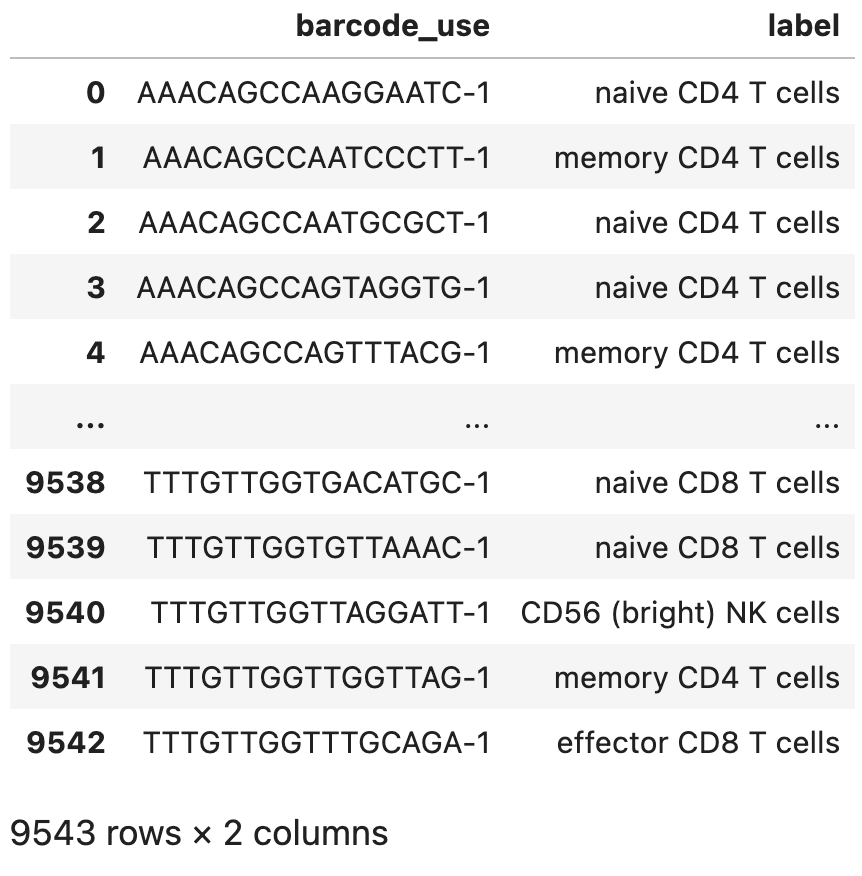

If the input data is 10X h5 file or h5ad file from scanpy, please follow the instruction h5/h5ad file as input .有另外一个教程文件

#### sc data

We provide the cell annotation as following:

In [1]:
import os
print("当前工作目录:", os.getcwd())  # 确认是否是 ~/LINGER

当前工作目录: /disk1/cai026/LINGER/Tutorial


## LINGER  
### install
略

### Preprocess
There are 2 options for the method we introduced above:

In [ ]:
#baseline;  
method='baseline' # this method is corresponding to bulkNN described in the paper

In [2]:
#LINGER; 
method='LINGER'

### Transfer the sc-multiome data to anndata
We will transfer sc-multiome data to the anndata format and filter the cell barcode by the cell type label.

In [3]:
import scanpy as sc
#set some figure parameters for nice display inside jupyternotebooks.
%matplotlib inline
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(5, 5), facecolor='white')
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
#results_file = "scRNA/pbmc10k.h5ad"
import scipy
import pandas as pd
matrix=scipy.io.mmread('/disk1/cai026/LINGER/data/filtered_feature_bc_matrix/matrix.mtx')
features=pd.read_csv('/disk1/cai026/LINGER/data/filtered_feature_bc_matrix/features.tsv',sep='\t',header=None)
barcodes=pd.read_csv('/disk1/cai026/LINGER/data/filtered_feature_bc_matrix/barcodes.tsv',sep='\t',header=None)
label=pd.read_csv('/disk1/cai026/LINGER/data/PBMC_label.txt',sep='\t',header=0)
from LingerGRN.preprocess import *
adata_RNA,adata_ATAC=get_adata(matrix,features,barcodes,label)# adata_RNA and adata_ATAC are scRNA and scATAC


#若是重新跑 这部分要重新跑

/disk1/cai026/mambaforge/envs/LINGER/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.5 anndata==0.9.2 umap==0.5.7 numpy==1.24.3 scipy==1.11.3 pandas==2.0.3 scikit-learn==1.3.0 statsmodels==0.14.1 pynndescent==0.5.13


/disk1/cai026/mambaforge/envs/LINGER/lib/python3.10/site-packages/LingerGRN/preprocess.py:278: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_RNA.obs['label']=label.loc[adata_RNA.obs['barcode']]['label'].values
/disk1/cai026/mambaforge/envs/LINGER/lib/python3.10/site-packages/LingerGRN/preprocess.py:281: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ATAC.obs['label']=label.loc[adata_ATAC.obs['barcode']]['label'].values


In [32]:
label

barcode_use                   label
barcode_use                                                   
AAACAGCCAAGGAATC-1  AAACAGCCAAGGAATC-1       naive CD4 T cells
AAACAGCCAATCCCTT-1  AAACAGCCAATCCCTT-1      memory CD4 T cells
AAACAGCCAATGCGCT-1  AAACAGCCAATGCGCT-1       naive CD4 T cells
AAACAGCCAGTAGGTG-1  AAACAGCCAGTAGGTG-1       naive CD4 T cells
AAACAGCCAGTTTACG-1  AAACAGCCAGTTTACG-1      memory CD4 T cells
...                                ...                     ...
TTTGTTGGTGACATGC-1  TTTGTTGGTGACATGC-1       naive CD8 T cells
TTTGTTGGTGTTAAAC-1  TTTGTTGGTGTTAAAC-1       naive CD8 T cells
TTTGTTGGTTAGGATT-1  TTTGTTGGTTAGGATT-1  CD56 (bright) NK cells
TTTGTTGGTTGGTTAG-1  TTTGTTGGTTGGTTAG-1      memory CD4 T cells
TTTGTTGGTTTGCAGA-1  TTTGTTGGTTTGCAGA-1    effector CD8 T cells

[9543 rows x 2 columns]

In [25]:
adata_RNA.write('/disk1/cai026/LINGER/data/adata_RNA.h5ad')

Trying to modify attribute `.obs` of view, initializing view as actual.


### Remove low counts cells and genes

In [4]:
import scanpy as sc
sc.pp.filter_cells(adata_RNA, min_genes=200)
sc.pp.filter_genes(adata_RNA, min_cells=3)
sc.pp.filter_cells(adata_ATAC, min_genes=200)
sc.pp.filter_genes(adata_ATAC, min_cells=3)
selected_barcode=list(set(adata_RNA.obs['barcode'].values)&set(adata_ATAC.obs['barcode'].values))
barcode_idx=pd.DataFrame(range(adata_RNA.shape[0]), index=adata_RNA.obs['barcode'].values)
adata_RNA = adata_RNA[barcode_idx.loc[selected_barcode][0]]
barcode_idx=pd.DataFrame(range(adata_ATAC.shape[0]), index=adata_ATAC.obs['barcode'].values)
adata_ATAC = adata_ATAC[barcode_idx.loc[selected_barcode][0]]

#若是重新跑 这部分要重新跑

/disk1/cai026/mambaforge/envs/LINGER/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


filtered out 11116 genes that are detected in less than 3 cells


/disk1/cai026/mambaforge/envs/LINGER/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


filtered out 2 genes that are detected in less than 3 cells


### Generate the pseudo-bulk/metacell:

用于 单细胞多组学数据（RNA + ATAC）的伪批量（pseudo-bulk）分析，主要目的是将单细胞级别的数据聚合成样本级别的表达矩阵，以便后续分析（如基因调控网络构建）。

In [5]:
from LingerGRN.pseudo_bulk import *
samplelist=list(set(adata_ATAC.obs['sample'].values)) # sample is generated from cell barcode 
tempsample=samplelist[0]
TG_pseudobulk=pd.DataFrame([])#初始化两个空的 DataFrame，分别用于存储 RNA 和 ATAC 的伪批量表达矩阵。
RE_pseudobulk=pd.DataFrame([])
singlepseudobulk = (adata_RNA.obs['sample'].unique().shape[0]*adata_RNA.obs['sample'].unique().shape[0]>100)
for tempsample in samplelist: #循环处理每个样本
    # 提取当前样本的 RNA 和 ATAC 数据
    adata_RNAtemp=adata_RNA[adata_RNA.obs['sample']==tempsample]
    adata_ATACtemp=adata_ATAC[adata_ATAC.obs['sample']==tempsample]
    # 调用 pseudo_bulk 函数生成伪批量矩阵
    TG_pseudobulk_temp,RE_pseudobulk_temp=pseudo_bulk(adata_RNAtemp,adata_ATACtemp,singlepseudobulk) 
    # 合并结果
    TG_pseudobulk=pd.concat([TG_pseudobulk, TG_pseudobulk_temp], axis=1)
    RE_pseudobulk=pd.concat([RE_pseudobulk, RE_pseudobulk_temp], axis=1)
    # 对 ATAC 数据截断（最大值设为 100） 防止异常值影响后续分析。
    RE_pseudobulk[RE_pseudobulk > 100] = 100

import os #数据保存
if not os.path.exists('data/'):
    os.mkdir('data/')
adata_ATAC.write('data/adata_ATAC.h5ad')
adata_RNA.write('data/adata_RNA.h5ad')
TG_pseudobulk=TG_pseudobulk.fillna(0)
RE_pseudobulk=RE_pseudobulk.fillna(0)
pd.DataFrame(adata_ATAC.var['gene_ids']).to_csv('data/Peaks.txt',header=None,index=None)
TG_pseudobulk.to_csv('data/TG_pseudobulk.tsv')
RE_pseudobulk.to_csv('data/RE_pseudobulk.tsv')

normalizing counts per cell
    finished (0:00:00)


/disk1/cai026/mambaforge/envs/LINGER/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/disk1/cai026/mambaforge/envs/LINGER/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing PCA
    on highly variable genes
    with n_comps=15
    finished (0:00:00)


/disk1/cai026/mambaforge/envs/LINGER/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/disk1/cai026/mambaforge/envs/LINGER/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing PCA
    on highly variable genes
    with n_comps=15
    finished (0:00:09)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)


/disk1/cai026/mambaforge/envs/LINGER/lib/python3.10/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/disk1/cai026/mambaforge/envs/LINGER/lib/python3.10/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


## Training model

**Overlap the region with general GRN:**

In [26]:
import pybedtools
pybedtools.helpers.set_bedtools_path("/disk1/cai026/mambaforge/envs/LINGER/bin")  # 替换为实际路径

In [27]:
from pybedtools import BedTool
print(dir(BedTool))

['TEMPFILES', '__add__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__weakref__', '_bed_to_bam', '_collapse', '_log_to_history', '_randomintersection', '_tabixed', '_tmp', 'absolute_distance', 'all_hits', 'annotate', 'any_hits', 'as_intervalfile', 'at', 'bam_to_bed', 'bam_to_fastq', 'bamtobed', 'bamtofastq', 'bed12tobed6', 'bed6', 'bedpe_to_bam', 'bedpetobam', 'bedtobam', 'bgzip', 'cat', 'check_genome', 'closest', 'cluster', 'colormap_normalize', 'complement', 'count', 'count_hits', 'coverage', 'cut', 'delete_temporary_history', 'each', 'expand', 'features', 'field_count', 'file_type', 'filter', 'fisher', 'flank', 'from_dataframe', 'genome_coverage', 'geno

In [28]:
import pybedtools

# 测试数据
a = pybedtools.BedTool("chr1 100 200", from_string=True)
b = pybedtools.BedTool("chr1 150 250", from_string=True)

# 检查交集
result = a.intersect(b)
print("测试结果:", result) # 应该输出 "chr1 100 200" 和 "chr1 150 250"

测试结果: chr1	150	200



In [20]:
from LingerGRN.preprocess import *
Datadir='/disk1/cai026/LINGER/Datadir/'# This directory should be the same as Datadir defined in the above 'Download the general gene regulatory network' section
GRNdir=Datadir+'data_bulk/'
genome='hg38'
outdir='/disk1/cai026/LINGER/output/' #output dir


#若是重新跑 这部分要重新跑

In [29]:
from LingerGRN.preprocess import *
Datadir='/disk1/cai026/LINGER/Datadir/'# This directory should be the same as Datadir defined in the above 'Download the general gene regulatory network' section
GRNdir=Datadir+'data_bulk/'
genome='hg38'
outdir='/disk1/cai026/LINGER/output/' #output dir
preprocess(TG_pseudobulk,RE_pseudobulk,GRNdir,genome,method,outdir)
#注意了 就是这一步将下载的bulk测序数据运用起来 生成文章里面说的GRN（TF-RE motif matching）
#如果是我 是否可以将这些bulk测序数据换成MDS的BULK数据
#感觉就是在这三者中取交集 分别是scRNA scATAC bulk 最后得到outdir里面的Motiftarget / Reigion_overlap文件
#所以这个preprocess函数真的是核心把

Mapping gene expression...
Generate TF expression...
Generate RE chromatin accessibility...
Generate TF binding...


100%|███████████████████████████████████████████████████████████████████████████████████████| 23/23 [04:06<00:00, 10.74s/it]


Generate Index...


100%|████████████████████████████████████████████████████████████████████████████████| 14907/14907 [00:23<00:00, 646.93it/s]


**Train for the LINGER model.**

In [30]:
import LingerGRN.LINGER_tr as LINGER_tr
activef='ReLU' # active function chose from 'ReLU','sigmoid','tanh'
LINGER_tr.training(GRNdir,method,outdir,activef,'Human')
#用的是CPU  还挺快的  牛B
#根据每个染色体上面的来 大约7h
#结果就是在output文件夹里面会出现 每天染色体的Loss.txt / net.pt(权重文件) / result.txt / shap.pt 文件

chr1


100%|███████████████████████████████████████████████████████████████████████████████████| 1520/1520 [34:30<00:00,  1.36s/it]


chr2


100%|█████████████████████████████████████████████████████████████████████████████████████| 976/976 [22:03<00:00,  1.36s/it]


chr3


100%|█████████████████████████████████████████████████████████████████████████████████████| 870/870 [19:46<00:00,  1.36s/it]


chr4


100%|█████████████████████████████████████████████████████████████████████████████████████| 565/565 [12:20<00:00,  1.31s/it]


chr5


100%|█████████████████████████████████████████████████████████████████████████████████████| 669/669 [14:53<00:00,  1.34s/it]


chr6


100%|█████████████████████████████████████████████████████████████████████████████████████| 759/759 [17:30<00:00,  1.38s/it]


chr7


100%|█████████████████████████████████████████████████████████████████████████████████████| 699/699 [15:51<00:00,  1.36s/it]


chr8


100%|█████████████████████████████████████████████████████████████████████████████████████| 508/508 [11:18<00:00,  1.34s/it]


chr9


100%|█████████████████████████████████████████████████████████████████████████████████████| 569/569 [13:06<00:00,  1.38s/it]


chr10


100%|█████████████████████████████████████████████████████████████████████████████████████| 562/562 [12:41<00:00,  1.36s/it]


chr11


100%|█████████████████████████████████████████████████████████████████████████████████████| 873/873 [20:10<00:00,  1.39s/it]


chr12


100%|█████████████████████████████████████████████████████████████████████████████████████| 833/833 [19:16<00:00,  1.39s/it]


chr13


100%|█████████████████████████████████████████████████████████████████████████████████████| 249/249 [05:30<00:00,  1.33s/it]


chr14


100%|█████████████████████████████████████████████████████████████████████████████████████| 473/473 [10:53<00:00,  1.38s/it]


chr15


100%|█████████████████████████████████████████████████████████████████████████████████████| 464/464 [10:31<00:00,  1.36s/it]


chr16


100%|█████████████████████████████████████████████████████████████████████████████████████| 675/675 [15:59<00:00,  1.42s/it]


chr17


100%|█████████████████████████████████████████████████████████████████████████████████████| 863/863 [20:44<00:00,  1.44s/it]


chr18


100%|█████████████████████████████████████████████████████████████████████████████████████| 210/210 [04:34<00:00,  1.31s/it]


chr19


100%|███████████████████████████████████████████████████████████████████████████████████| 1149/1149 [27:57<00:00,  1.46s/it]


chr20


100%|█████████████████████████████████████████████████████████████████████████████████████| 403/403 [09:23<00:00,  1.40s/it]


chr21


100%|█████████████████████████████████████████████████████████████████████████████████████| 139/139 [03:10<00:00,  1.37s/it]


chr22


100%|█████████████████████████████████████████████████████████████████████████████████████| 345/345 [08:11<00:00,  1.42s/it]


chrX


100%|█████████████████████████████████████████████████████████████████████████████████████| 534/534 [11:20<00:00,  1.28s/it]


In [ ]:
import LingerGRN.LINGER_tr as LINGER_tr


### Cell population gene regulatory network
细胞群

**TF binding potential**  
The output is 'cell_population_TF_RE_binding.txt', a matrix of the TF-RE binding score.

In [7]:
import LingerGRN.LL_net as LL_net
LL_net.TF_RE_binding(GRNdir,adata_RNA,adata_ATAC,genome,method,outdir)
#在output文件夹里面出现 cell population_TF_RE_binding.txt 还有 每个染色体的这个文件

Generating cellular population TF binding strength ...


  0%|                                                                                                | 0/23 [00:00<?, ?it/s]

Generating cellular population TF binding strength for chr1



  4%|███▋                                                                                 | 1/23 [03:10<1:09:57, 190.80s/it]

Generating cellular population TF binding strength for chr2



  9%|███████▌                                                                               | 2/23 [04:49<47:50, 136.71s/it]

Generating cellular population TF binding strength for chr3



 13%|███████████▎                                                                           | 3/23 [06:15<37:53, 113.70s/it]

Generating cellular population TF binding strength for chr4



 17%|███████████████▎                                                                        | 4/23 [06:55<26:47, 84.60s/it]

Generating cellular population TF binding strength for chr5



 22%|███████████████████▏                                                                    | 5/23 [07:53<22:24, 74.70s/it]

Generating cellular population TF binding strength for chr6



 26%|██████████████████████▉                                                                 | 6/23 [09:26<22:59, 81.14s/it]

Generating cellular population TF binding strength for chr7



 30%|██████████████████████████▊                                                             | 7/23 [10:38<20:50, 78.14s/it]

Generating cellular population TF binding strength for chr8



 35%|██████████████████████████████▌                                                         | 8/23 [11:26<17:08, 68.54s/it]

Generating cellular population TF binding strength for chr9



 39%|██████████████████████████████████▍                                                     | 9/23 [12:38<16:13, 69.55s/it]

Generating cellular population TF binding strength for chr10



 43%|█████████████████████████████████████▊                                                 | 10/23 [13:35<14:12, 65.60s/it]

Generating cellular population TF binding strength for chr11



 48%|█████████████████████████████████████████▌                                             | 11/23 [15:30<16:10, 80.87s/it]

Generating cellular population TF binding strength for chr12



 52%|█████████████████████████████████████████████▍                                         | 12/23 [17:16<16:11, 88.34s/it]

Generating cellular population TF binding strength for chr13



 57%|█████████████████████████████████████████████████▏                                     | 13/23 [17:37<11:19, 67.92s/it]

Generating cellular population TF binding strength for chr14



 61%|████████████████████████████████████████████████████▉                                  | 14/23 [18:31<09:35, 63.92s/it]

Generating cellular population TF binding strength for chr15



 65%|████████████████████████████████████████████████████████▋                              | 15/23 [19:26<08:09, 61.14s/it]

Generating cellular population TF binding strength for chr16



 70%|████████████████████████████████████████████████████████████▌                          | 16/23 [21:06<08:29, 72.74s/it]

Generating cellular population TF binding strength for chr17



 74%|████████████████████████████████████████████████████████████████▎                      | 17/23 [23:38<09:39, 96.57s/it]

Generating cellular population TF binding strength for chr18



 78%|████████████████████████████████████████████████████████████████████                   | 18/23 [23:54<06:01, 72.36s/it]

Generating cellular population TF binding strength for chr19



 83%|███████████████████████████████████████████████████████████████████████               | 19/23 [27:32<07:44, 116.07s/it]

Generating cellular population TF binding strength for chr20



 87%|███████████████████████████████████████████████████████████████████████████▋           | 20/23 [28:22<04:48, 96.31s/it]

Generating cellular population TF binding strength for chr21



 91%|███████████████████████████████████████████████████████████████████████████████▍       | 21/23 [28:37<02:24, 72.11s/it]

Generating cellular population TF binding strength for chr22



 96%|███████████████████████████████████████████████████████████████████████████████████▏   | 22/23 [29:31<01:06, 66.45s/it]

Generating cellular population TF binding strength for chrX



100%|███████████████████████████████████████████████████████████████████████████████████████| 23/23 [30:02<00:00, 78.37s/it]


本来是因为代码错误  要修改代码 所以要重新跑代码   
但是上一步的LL_net没有得出来  
所以我想直接在output文件夹里面直接加载LL_NET对象 但是把代码发给AI看之后不知道如何把23对染色体的pt文件全部合在一起变成一个对象  
所以最后只好重新跑 速度还是挺快的

**cis-regulatory network**  
The output is 'cell_population_cis_regulatory.txt' with 3 columns: region, target gene, cis-regulatory score.

In [9]:
LL_net.cis_reg(GRNdir,adata_RNA,adata_ATAC,genome,method,outdir)
#只生成一个文件 cell_population_cis_regulatory.txt

100%|███████████████████████████████████████████████████████████████████████████████████████| 23/23 [01:37<00:00,  4.25s/it]


**trans-regulatory network**  
The output is 'cell_population_trans_regulatory.txt', a matrix of the trans-regulatory score.

In [10]:
LL_net.trans_reg(GRNdir,method,outdir,genome)
#只生成一个文件 cell_population_trans_regulatory.txt

Generate trans-regulatory netowrk ...


100%|███████████████████████████████████████████████████████████████████████████████████████| 23/23 [01:55<00:00,  5.03s/it]


Save trans-regulatory netowrk ...


### Cell type sepecific gene regulaory network
特定细胞类型
There are 2 options:

1. infer GRN for a specific cell type, which is in the label.txt;

In [16]:
celltype='CD56 (bright) NK cells' #use a string to assign your cell type

2. infer GRNs for all cell types.

In [18]:
celltype='all'

Please make sure that 'all' is not a cell type in your data.

**TF binding potential**  
The output is 'cell_population_TF_RE_binding_celltype.txt', a matrix of the TF-RE binding potential.

In [13]:
LL_net.cell_type_specific_TF_RE_binding(GRNdir,adata_RNA,adata_ATAC,genome,celltype,outdir,method)# different from the previous version
#产生多个cell_type_specific_TF_RE_binding_{celltype}.txt

Generate cell type specitic TF binding potential for cell type memory CD4 T cells...


100%|███████████████████████████████████████████████████████████████████████████████████████| 22/22 [04:07<00:00, 11.23s/it]


Generate cell type specitic TF binding potential for cell type naive CD8 T cells...


100%|███████████████████████████████████████████████████████████████████████████████████████| 22/22 [04:12<00:00, 11.48s/it]


Generate cell type specitic TF binding potential for cell type classical monocytes...


100%|███████████████████████████████████████████████████████████████████████████████████████| 22/22 [04:09<00:00, 11.32s/it]


Generate cell type specitic TF binding potential for cell type non-classical monocytes...


100%|███████████████████████████████████████████████████████████████████████████████████████| 22/22 [03:24<00:00,  9.29s/it]


Generate cell type specitic TF binding potential for cell type CD56 (bright) NK cells...


100%|███████████████████████████████████████████████████████████████████████████████████████| 22/22 [02:35<00:00,  7.08s/it]


Generate cell type specitic TF binding potential for cell type effector CD8 T cells...


100%|███████████████████████████████████████████████████████████████████████████████████████| 22/22 [02:36<00:00,  7.13s/it]


Generate cell type specitic TF binding potential for cell type naive B cells...


100%|███████████████████████████████████████████████████████████████████████████████████████| 22/22 [02:35<00:00,  7.09s/it]


Generate cell type specitic TF binding potential for cell type plasmacytoid DC...


100%|███████████████████████████████████████████████████████████████████████████████████████| 22/22 [02:48<00:00,  7.68s/it]


Generate cell type specitic TF binding potential for cell type myeloid DC...


100%|███████████████████████████████████████████████████████████████████████████████████████| 22/22 [02:36<00:00,  7.10s/it]


Generate cell type specitic TF binding potential for cell type naive CD4 T cells...


100%|███████████████████████████████████████████████████████████████████████████████████████| 22/22 [02:49<00:00,  7.68s/it]


Generate cell type specitic TF binding potential for cell type MAIT T cells...


100%|███████████████████████████████████████████████████████████████████████████████████████| 22/22 [03:16<00:00,  8.93s/it]


Generate cell type specitic TF binding potential for cell type intermediate monocytes...


100%|███████████████████████████████████████████████████████████████████████████████████████| 22/22 [03:05<00:00,  8.44s/it]


Generate cell type specitic TF binding potential for cell type memory B cells...


100%|███████████████████████████████████████████████████████████████████████████████████████| 22/22 [02:55<00:00,  7.98s/it]


Generate cell type specitic TF binding potential for cell type CD56 (dim) NK cells...


100%|███████████████████████████████████████████████████████████████████████████████████████| 22/22 [02:48<00:00,  7.67s/it]


**cis-regulatory network**  
The output is 'cell_type_specific_cis_regulatory_{celltype}.txt' with 3 columns: region, target gene, cis-regulatory score.

In [22]:
LL_net.cell_type_specific_cis_reg(GRNdir,adata_RNA,adata_ATAC,genome,celltype,outdir,method)
#这里的method参数注意 根据LL_net.py 里面的函数  应该是放在最后的  不然会产生读取错误
#产生多个cell_type_specific_cis_regulatory_{celltype}.txt

100%|███████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:44<00:00,  1.95s/it]


**trans-regulatory network**  
The output is 'cell_type_specific_trans_regulatory_{celltype}.txt', a matrix of the trans-regulatory score.

In [23]:
LL_net.cell_type_specific_trans_reg(GRNdir,adata_RNA,celltype,outdir)
#产生多个cell_type_specific_trans_regulatory_{celltype}.txt

## Identify driver regulators by TF activity
下游应用
### Instruction
TF activity, focusing on the DNA-binding component of TF proteins in the nucleus, is a more reliable metric than mRNA or whole protein expression for identifying driver regulators. Here, we employed LINGER inferred GRNs from sc-multiome data of a single individual. Assuming the GRN structure is consistent across individuals, we estimated TF activity using gene expression data alone. By comparing TF activity between cases and controls, we identified driver regulators.  
与 mRNA 或整个蛋白质的表达相比，TF 活性是识别驱动调节因子的一个更可靠的指标。在这里，我们利用 LINGER 从单个个体的 sc-multiome 数据中推断出 GRN。假定不同个体的 GRN 结构是一致的，我们仅使用基因表达数据来估计 TF 活性。通过比较病例和对照组的 TF 活性，我们确定了驱动调节因子。

### Prepare
We need to trans-regulatory network, you can choose a network match you data best.

1. If there is not single cell avaliable to infer the cell population and cell type specific GRN, you can choose a GRN from various tissues.

In [ ]:
network = 'general'

2. If your gene expression data are matched with cell population GRN, you can set

In [24]:
network = 'cell population'

3. If your gene expression data are matched with certain cell type, you can set network to the name of this cell type.

In [2]:
network = 'CD56 (bright) NK cells' # CD56 (bright) NK cells is the name of one cell type

### Calculate TF activity  
The input is gene expression data, It could be the scRNA-seq data from the sc multiome data. It could be other sc or bulk RNA-seq data matches the GRN. The row of gene expresion data is gene, columns is sample and the value is read count (sc) or FPKM/RPKM (bulk).  
输入是基因表达数据，可以是 sc 多组数据中的 scRNA-seq 数据。也可能是与 GRN 匹配的其他 sc 或批量 RNA-seq 数据。基因表达数据的行为基因，列为样本，值为读数（sc）或 FPKM/RPKM（bulk）。

In [26]:
import anndata
from LingerGRN.TF_activity import *
Datadir='/disk1/cai026/LINGER/Datadir/'# This directory should be the same as Datadir defined in the above 'Download the general gene regulatory network' section
GRNdir=Datadir+'data_bulk/'
genome='hg38'
outdir='/disk1/cai026/LINGER/output/' #output dir

adata_RNA=anndata.read_h5ad('/disk1/cai026/LINGER/data/adata_RNA.h5ad')
TF_activity=regulon(outdir,adata_RNA,GRNdir,network,genome)


In [ ]:
Datadir='/zfs/durenlab/palmetto/Kaya/SC_NET/code/github/combine/'# this directory should be the same with Datadir
GRNdir=Datadir+'data_bulk/'
genome='hg38'
from LingerGRN.TF_activity import *
outdir='/zfs/durenlab/palmetto/Kaya/SC_NET/code/github/combine/LINGER/examples/output/' #output dir
import anndata
adata_RNA=anndata.read_h5ad('/disk1/cai026/LINGER/data/adata_RNA.h5ad')
TF_activity=regulon(outdir,adata_RNA,GRNdir,network,genome)

#这里因为找不到adata_RNA.h5ad  所以直接把上面的adata_RNA拿来用了

Visualize the TF activity heatmap by cluster. If you want to save the heatmap to outdit, please set 'save=True'. The output is 'heatmap_activity.png'.

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


<Figure size 640x480 with 0 Axes>

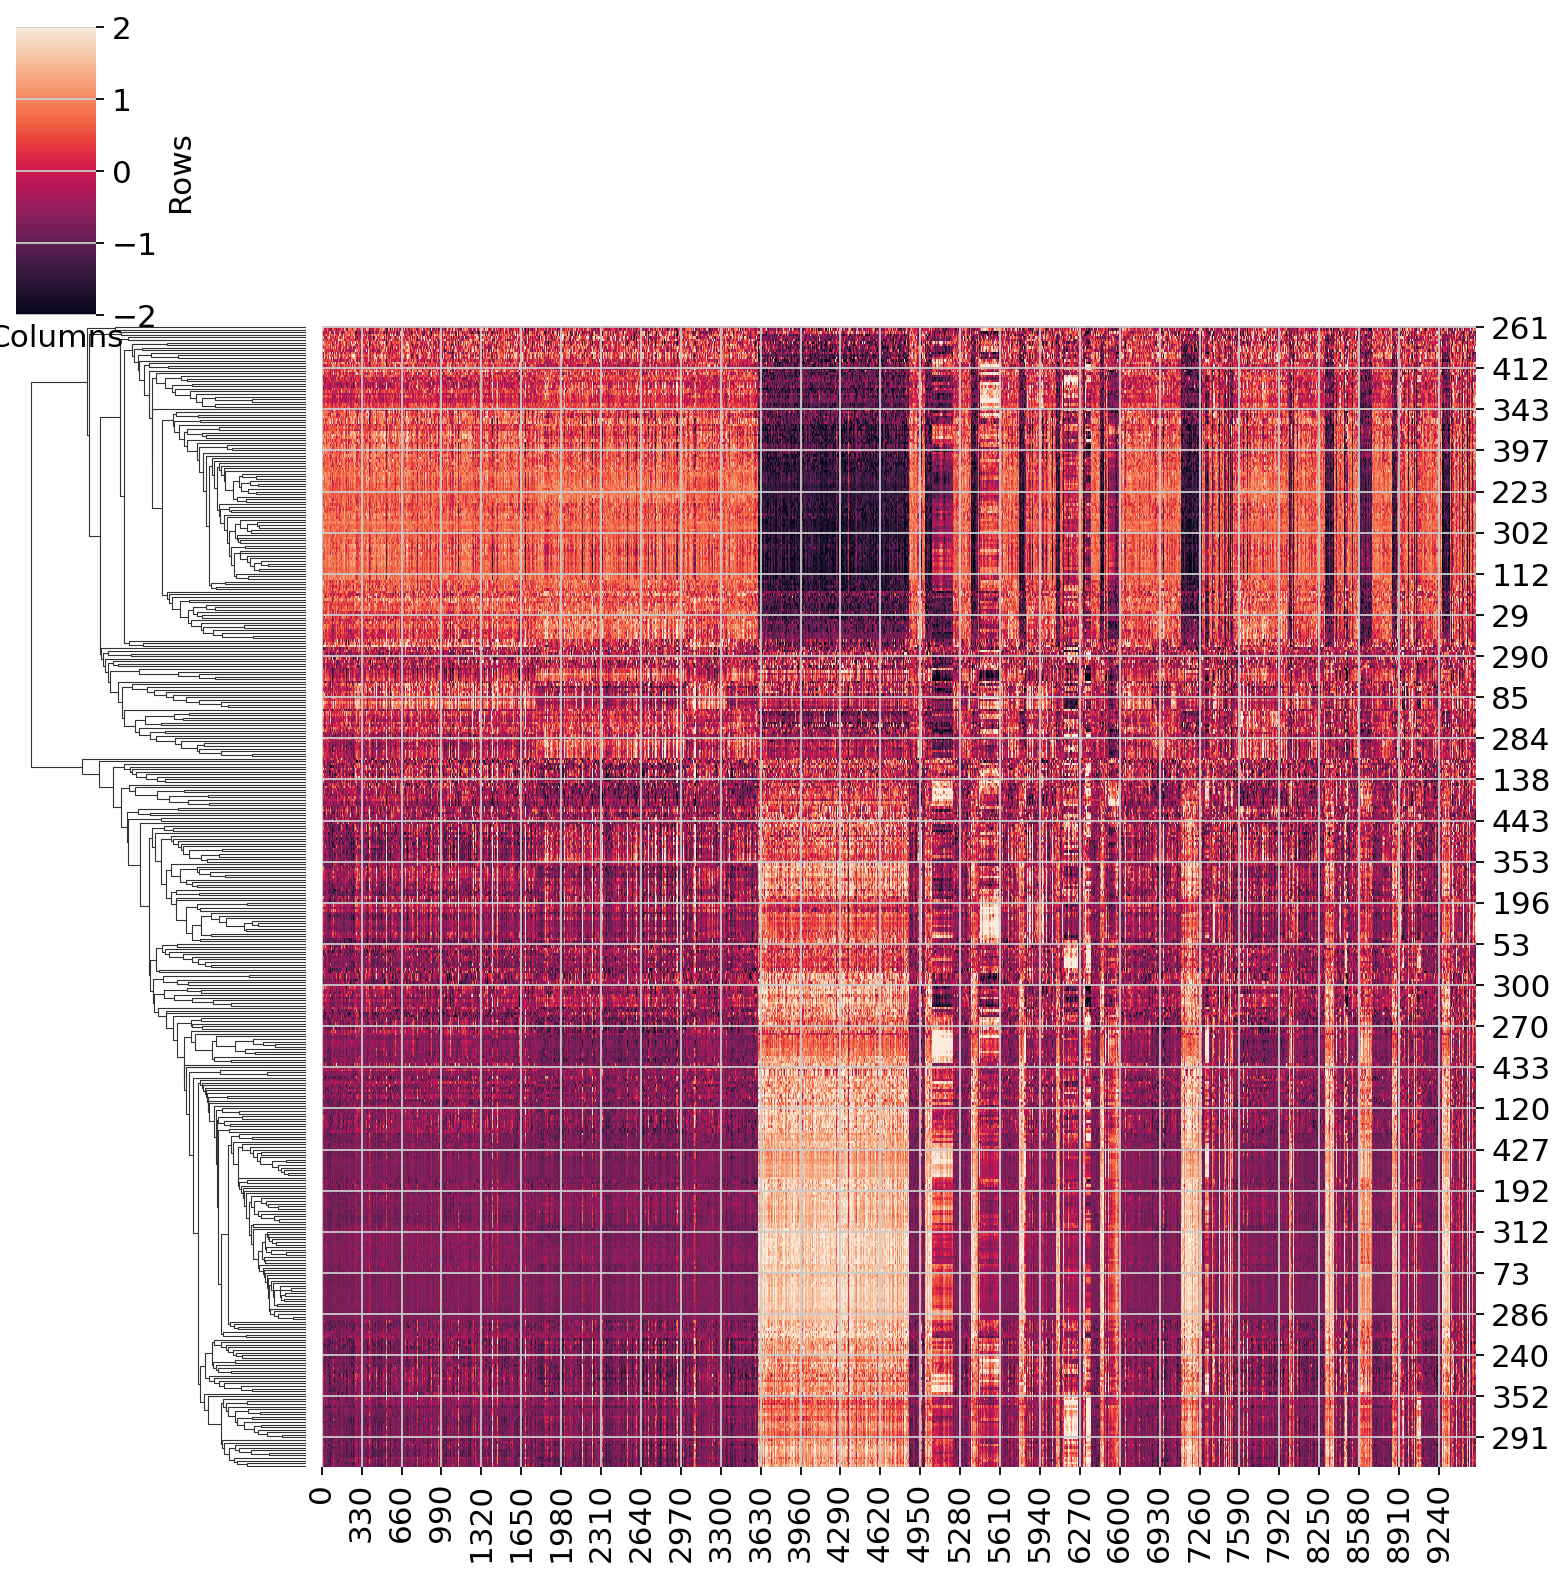

In [27]:
save=True
heatmap_cluster(TF_activity,adata_RNA,save,outdir)
#这里出的图和教程里面的确实不一样  但是横纵轴里面的数字代表什么意思还是不太明白

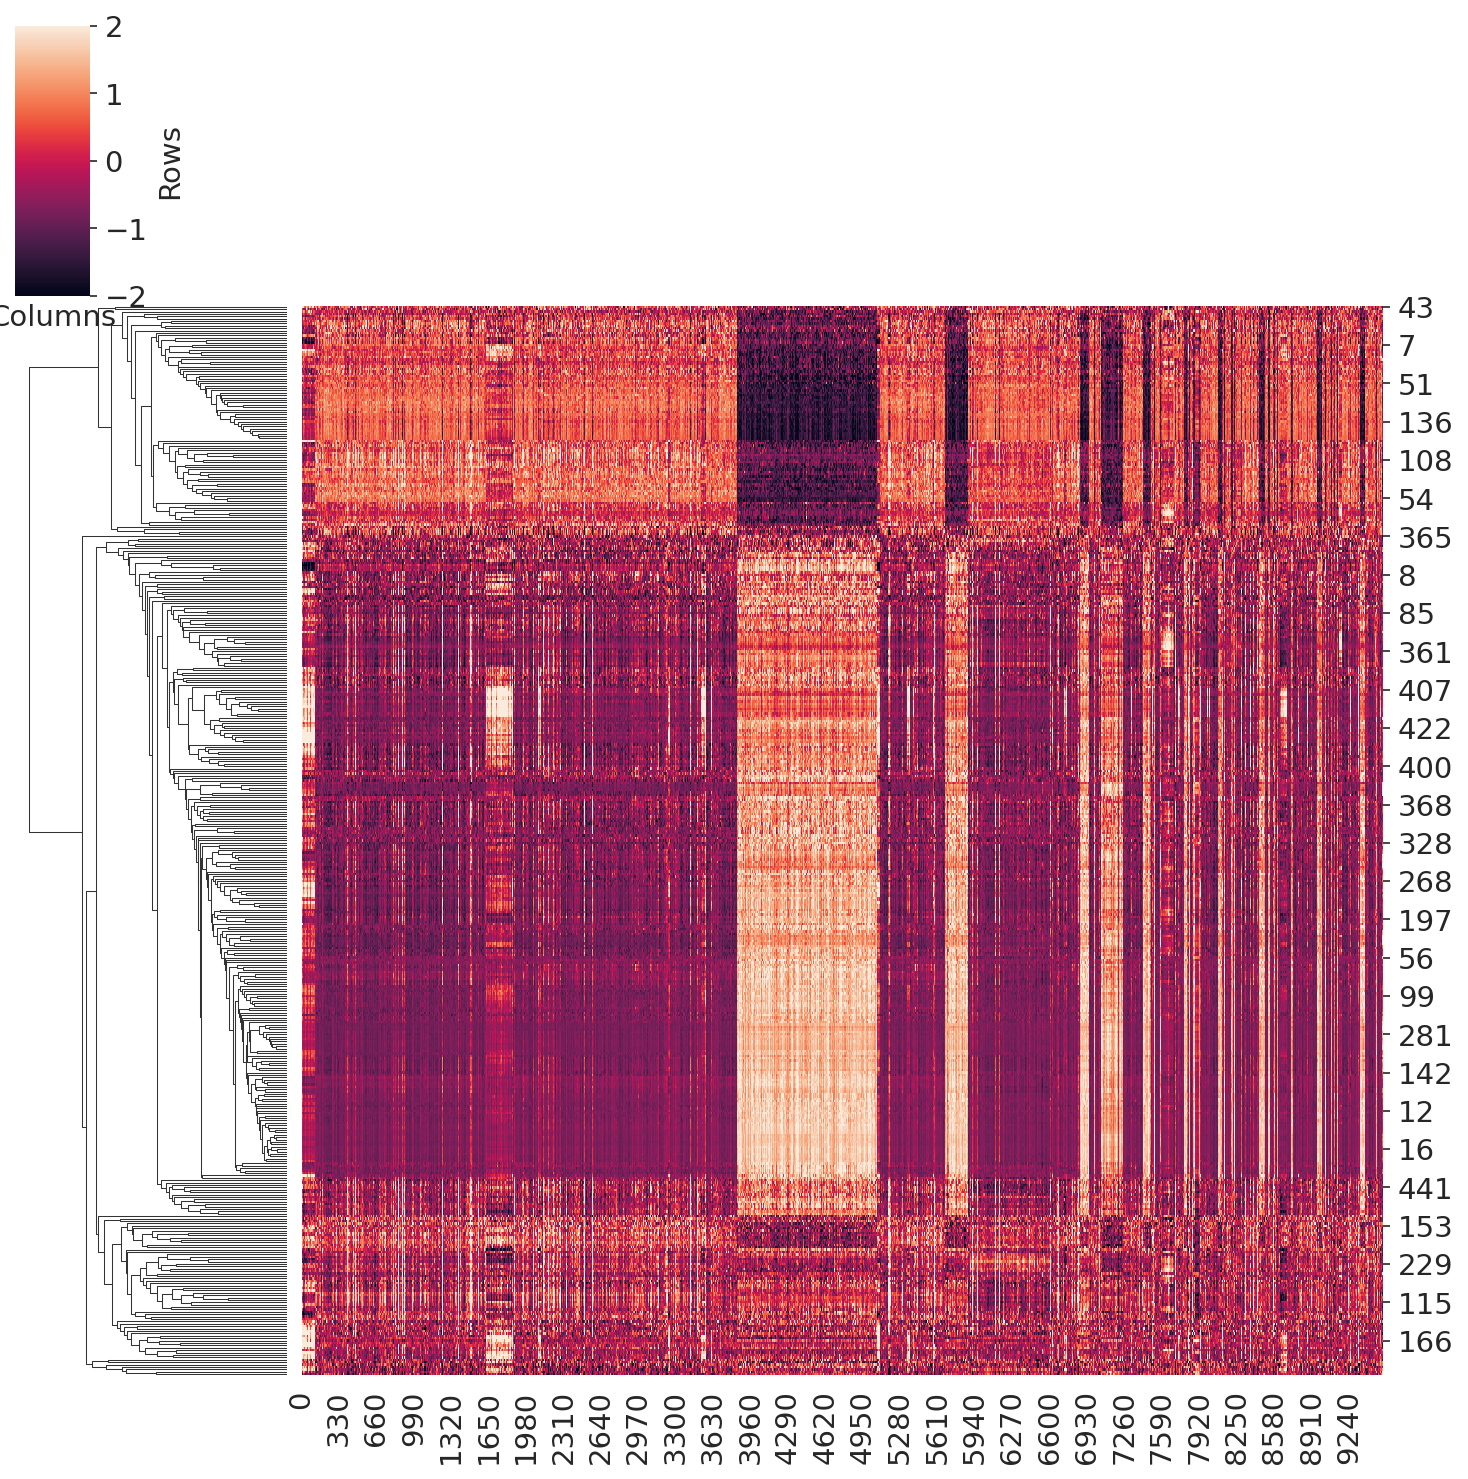

## Identify driver regulator
We use t-test to find the differential TFs of a certain cell type by the activity.

1. You can assign a certain cell type of the gene expression data by

In [ ]:
celltype='CD56 (bright) NK cells'

2. Or, you can obtain the result for all cell types.

In [ ]:
celltype='all'

For example,

In [28]:
celltype='CD56 (bright) NK cells'
t_test_results=master_regulator(TF_activity,adata_RNA,celltype)
t_test_results

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.


t_stat   p_value     adj_p
AHR      -2.999651  0.998645  1.000000
AIRE     -7.317083  1.000000  1.000000
ALX3     -3.832329  0.999936  1.000000
ALX4     50.632972  0.000000  0.000000
AR        0.615054  0.269267  0.559628
...            ...       ...       ...
ZNF423   -2.941467  0.998363  1.000000
ZNF691    3.820221  0.000067  0.000168
ZNF711   -2.604439  0.995392  1.000000
ZNF740    4.646881  0.000002  0.000005
ZSCAN22 -19.493139  1.000000  1.000000

[451 rows x 3 columns]

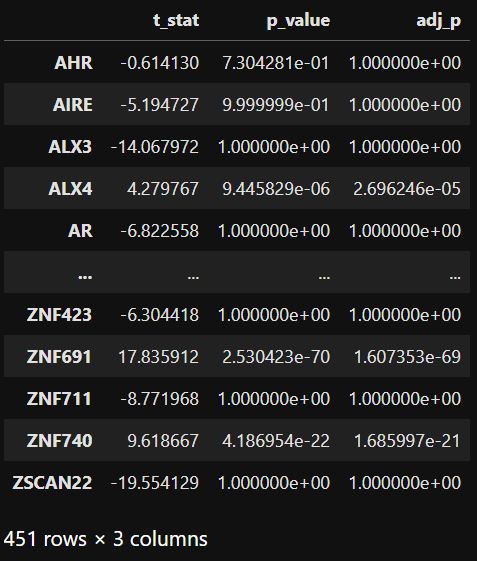

Visulize the differential activity and expression. You can compare 2 different cell types and one cell type with other cell types. If you want to save the heatmap to outdit, please set 'save=True'. The output is 'box_plot'+TFName+''+datatype+''+celltype1+''+celltype2+'.png'.  
细胞类型间比较

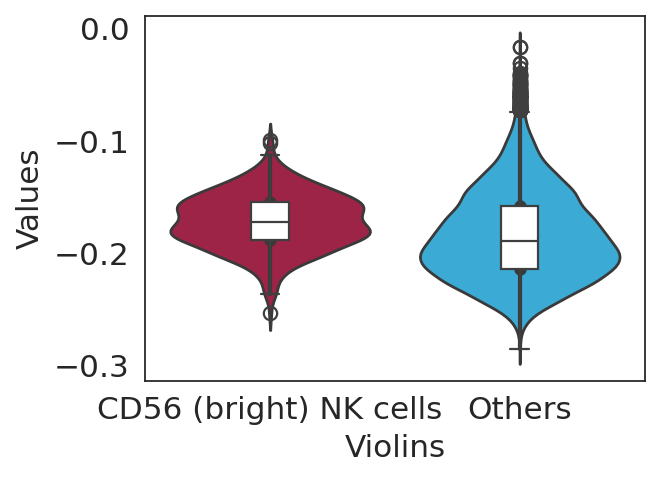

In [29]:
TFName='ATF1'  #必须是TF
datatype='activity'  #除了活性还有别的吗？
celltype1='CD56 (bright) NK cells'
celltype2='Others'
save=True
box_comp(TFName,adata_RNA,celltype1,celltype2,datatype,TF_activity,save,outdir)

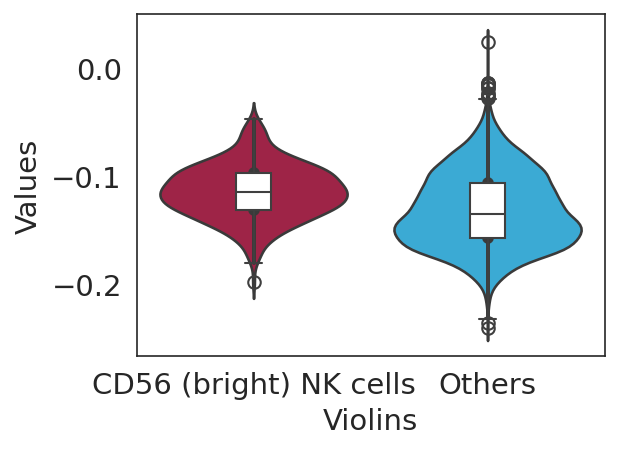

For gene expression data, the boxplot is:

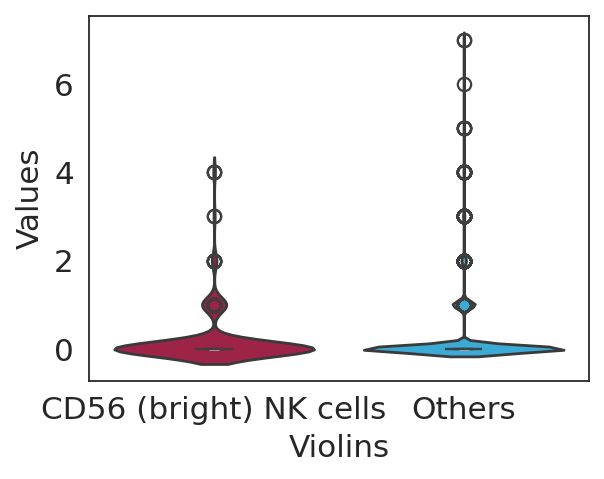

In [30]:
datatype='expression' #除了活性还有表达 那这优点拉跨
box_comp(TFName,adata_RNA,celltype1,celltype2,datatype,TF_activity,save,outdir)

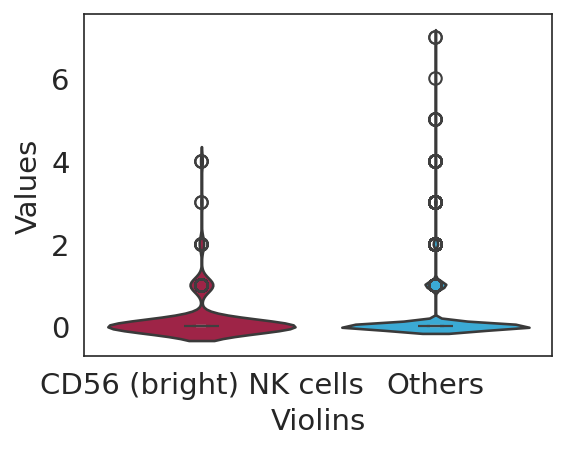

## Note
1. The cell specific GRN is based on the output of the cell population GRN.
2. If we want to try 2 different method options, we can create 2 output directory.